# Library Install & Import

In [ ]:
file_content = """
unsloth @ git+https://github.com/unslothai/unsloth.git@4211cc01409e3ced4f7abebaf68e244193b46e2c
xformers==0.0.25.post1
trl==0.8.6
peft==0.10.0
accelerate==0.30.1
bitsandbytes==0.43.1
huggingface-hub==0.23.0
"""
with open("requirements.txt", "w") as f:
    f.write(file_content)

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install -r requirements.txt
!pip install sentence-transformers
!pip install dash
!pip install dash-core-components
!pip install dash-html-components
!pip install hdbscan
!pip install umap-learn
# !pip install ace_tools

In [ ]:
# importing libraries
import hdbscan
import random
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import re
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.datasets import make_blobs
import math
from unsloth import FastLanguageModel
import torch
import random
import matplotlib.pyplot as plt
import umap
# import ace_tools as tools

<ipython-input-2-f3beed1f2c42>:20: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-2-f3beed1f2c42>:21: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


# Data Preprocessing

In [ ]:
pd.options.display.max_colwidth = 150
df = pd.read_csv("/content/data.csv")
df

,title,topic,listing_id,price,quantity,views,est_sales,favorites,tags,category,categories,title.1,original_creation,last_modified,fixed_title
0,"Funny CPA Shirt Accountant Shirt CPA Shirt Cpa Gift New Cpa Shirt Gift CPA No Crying During Tax Season, Premium Mens Womens Unisex Shirt",Accounting,979914529,2658,998,111.0,2,NaN,"Funny CPA Shirt, Accountant Shirt, CPA Shirt, Cpa Gift, New cpa Shirt, Gift for cpa, Accountant Gift, cpa Exam, No Crying During, Tax Season, Acco...",T-shirts,Clothing > Unisex Adult Clothing > Tops & Tees > T-shirts,"Funny CPA Shirt Accountant Shirt CPA Shirt Cpa Gift New Cpa Shirt Gift CPA No Crying During Tax Season, Premium Mens Womens Unisex Shirt",2021-03-13T00:30:58Z,2023-06-08T00:40:59Z,cpa accountant cpa cpa new cpa cpa no crying during tax season
1,"Funny CPA Shirt Accountant Shirt CPA Shirt Cpa Gift New Cpa Shirt Gift CPA No Crying During Tax Season, Premium Mens Womens Unisex Shirt",Accounting,979914729,1992,49949,113.0,2,2.0,"Funny CPA Shirt, Accountant Shirt, CPA Shirt, Cpa Gift, New cpa Shirt, Gift for cpa, Accountant Gift, cpa Exam, No Crying During, Tax Season, Acco...",T-shirts,Clothing > Unisex Adult Clothing > Tops & Tees > T-shirts,"Funny CPA Shirt Accountant Shirt CPA Shirt Cpa Gift New Cpa Shirt Gift CPA No Crying During Tax Season, Premium Mens Womens Unisex Shirt",2021-03-13T00:31:25Z,2024-06-03T18:50:31Z,cpa accountant cpa cpa new cpa cpa no crying during tax season
2,Being An Accountant Is Easy Shirt Funny Accountant Shirt Funny Accountant Gift CPA Shirt Premium Gift Him Her Unisex Adult Mens Womens Shirt,Accounting,980003279,1992,49949,349.0,8,4.0,"accountant shirt, accountant gift, accountant tee, Office Worker, CPA Shirt, CPA Gifts, Funny Accounting Tee, New CPA Shirt, Gift For CPA, Book Ke...",T-shirts,Clothing > Unisex Adult Clothing > Tops & Tees > T-shirts,Being An Accountant Is Easy Shirt Funny Accountant Shirt Funny Accountant Gift CPA Shirt Premium Gift Him Her Unisex Adult Mens Womens Shirt,2021-03-13T03:47:05Z,2023-08-04T18:11:37Z,being an accountant is easy accountant accountant cpa her adult
3,Being An Accountant Is Easy Shirt Funny Accountant Shirt Funny Accountant Gift CPA Shirt Premium Gift Him Her Unisex Adult Mens Womens Shirt,Accounting,966034092,1992,49944,6138.0,151,190.0,"accountant shirt, accountant gift, accountant tee, Office Worker, CPA Shirt, CPA Gifts, Funny Accounting Tee, New CPA Shirt, Gift For CPA, Book Ke...",T-shirts,Clothing > Unisex Adult Clothing > Tops & Tees > T-shirts,Being An Accountant Is Easy Shirt Funny Accountant Shirt Funny Accountant Gift CPA Shirt Premium Gift Him Her Unisex Adult Mens Womens Shirt,2021-03-13T03:46:37Z,2024-05-14T20:52:55Z,being an accountant is easy accountant accountant cpa her adult
4,I Have A Spreadsheet For That Office Worker Shirt Data Analyst Shirt Accountant Shirt Gift For Actuary Statistician Gifts Finance Gift,Accounting,1375212107,1992,44953,56.0,1,3.0,"Love Spreadsheets, Novelty Birthday, Christmas, Anniversary, Gag Gifts Idea, CPA Tax, accountant gifts, office appreciation, data science, data lo...",T-shirts,Clothing > Gender-Neutral Adult Clothing > Tops & Tees > T-shirts,I Have A Spreadsheet For That Office Worker Shirt Data Analyst Shirt Accountant Shirt Gift For Actuary Statistician Gifts Finance Gift,2022-12-20T03:44:19Z,2024-05-15T19:30:33Z,i have a spreadsheet for that office worker data analyst accountant for actuary statistician finance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6366,Pickleball Shirt for Women Her Pickleballer Gifts Christmas Paddle Dink Birthday Retro Vintage Mom Daughter Game Day Tournament Player Gift,Women's Fashion,1384730118,1992,39960,20.0,0,NaN,"Pickleball shirt, pickleball gifts, pickleball christmas, pickleball daughter, pickleball mom, pickle ball shirt, Racquetball shirt, pickleball pa...",T-shirts,Clothing > Gender-Neutral Adult Clothing > Tops & Tees > T-shirts,Pickleball Shirt for Women Her Pickleballer Gifts Christmas Paddle Dink Birthday R

In [ ]:
df['category'].value_counts()

category
T-shirts                  6249
Hoodies                     67
Mugs                        21
Sweatshirts                  7
Face Masks & Coverings       5
Skin Treatment Masks         5
Name: count, dtype: int64

# SBERT for Embedder

In [ ]:
# Set a random seed
random_seed = 42
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

In [ ]:
# # Load BERT tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
# model = BertModel.from_pretrained('bert-large-uncased')
# model = model.to("cuda")

from sentence_transformers import SentenceTransformer

# Load the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def reformat_spacing(sentence):
    # Split the sentence into words (this will remove extra spaces)
    words = sentence.split()
    # Join the words back together with a single space
    formatted_sentence = ' '.join(words)
    return formatted_sentence

def remove_words_containing_substring(sentence, substring):
    # Define the regex pattern to match whole words containing the substring
    pattern = r'\b\w*' + re.escape(substring) + r'\w*\b'
    # Replace matching words with an empty string
    result = re.sub(pattern, '', sentence)
    # Remove any extra spaces that might have been left
    result = re.sub(r'\s+', ' ', result).strip()
    return result

i = 0
t_list = df['title'].tolist()
pt_list = []
#---------------------------------------------------------------------------------------------------------------
for t in t_list:
    re_list = ["t shirt", "tshirt", "t-shirt", "shirts", "shirt", "tee", "gift",
               "premium men woman unisex", "premium", "bella+canvas",
               "unisex", "heavy", "cotton", "comfort", "colors",
               "hoodies", "hoodie", "mugs", "sweatshirts", "funny", "adults", "adult"
               "face masks & coverings", "face masks", "woman", "man", "him", "her"
               "coverings", "skin treatment masks", "bella canvas", "mens", "womens", "men", "women"]
#---------------------------------------------------------------------------------------------------------------

    tmp = t.lower()
    for r in re_list:
        tmp = remove_words_containing_substring(tmp, r)
    # tmp = tmp.replace(",,,,", ",")
    # tmp = tmp.replace(",,,", ",")
    # tmp = tmp.replace(",,", ",")
    # tmp = tmp.replace(" ,", ",")
    tmp = tmp.strip()
    if tmp[-1] == ",":
        tmp = tmp[:-1]
    if tmp[0] == "®":
        tmp = tmp[1:]
    tmp = tmp.strip()
    tmp = reformat_spacing(tmp)
    pt_list.append(tmp)

df['fixed_title'] = pt_list
t_list = pt_list
t_list = list(set(t_list))

In [ ]:
# e_list = []
# for t in tqdm(t_list):
#     encoding = tokenizer.batch_encode_plus([t], padding=True, truncation=True, return_tensors='pt', add_special_tokens=True)
#     input_ids = encoding['input_ids'].to("cuda")
#     attention_mask = encoding['attention_mask'].to("cuda")
#     with torch.no_grad():
#         outputs = model(input_ids, attention_mask=attention_mask)
#         word_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # This contains the embeddings
#         word_embeddings = word_embeddings.reshape(-1)

#     e_list.append(word_embeddings)

e_list = []
for t in tqdm(t_list):
    with torch.no_grad():
        word_embeddings = model.encode(t)

    e_list.append(word_embeddings)

100%|██████████| 2549/2549 [00:19<00:00, 132.62it/s]


# Word Cloud after preprocessing

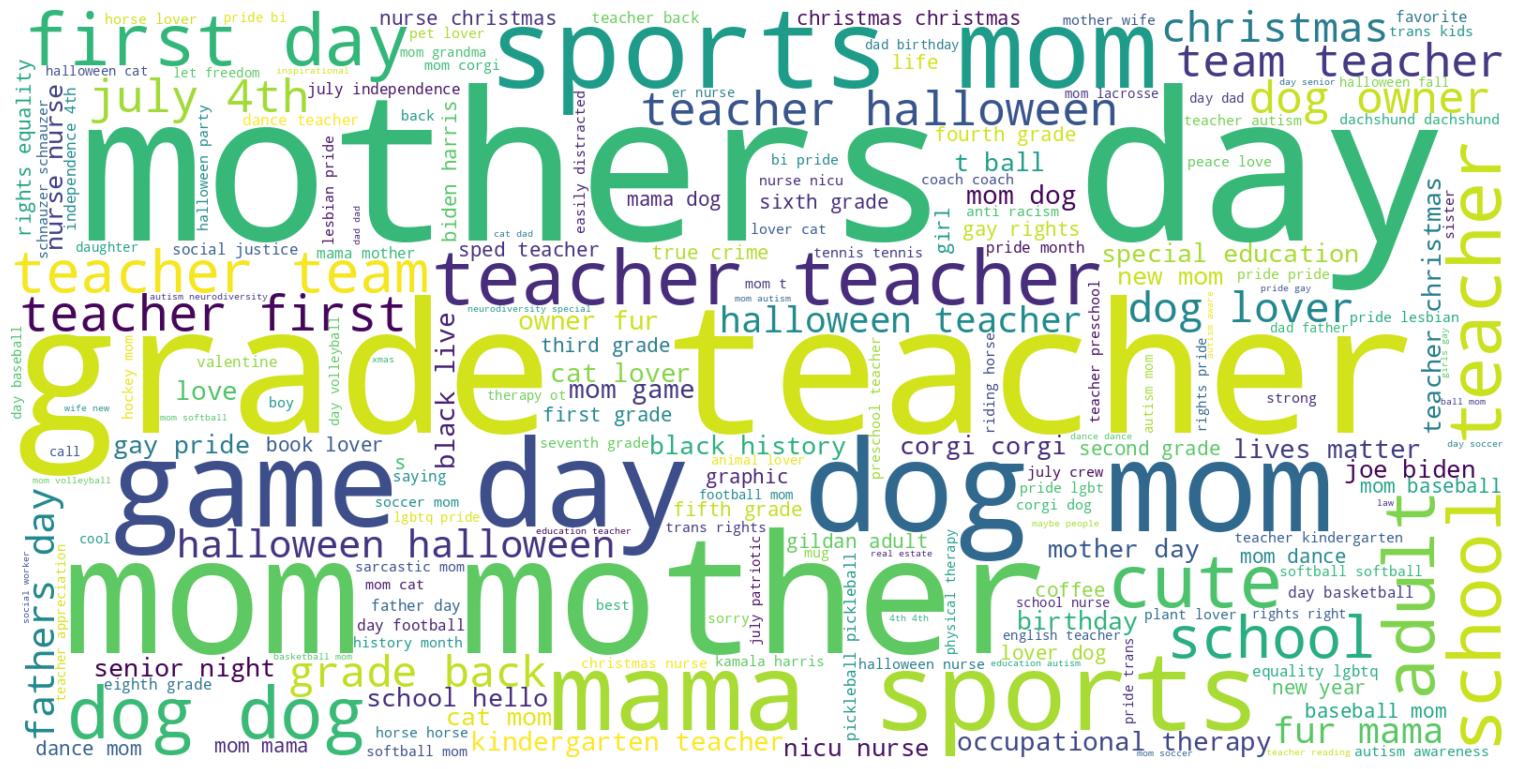

In [ ]:
# @title Word Cloud Generate
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.fixed_title:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (15, 8), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

# Scale and reduce data dimensions

In [ ]:
#Tiền xử lý + giảm dữ liệu xuống dạng 2 chiều
print("Scaling data...")
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(e_list))
# scaled_data = pd.DataFrame(e_list)

print("Done!")
print("Reducing to number of dimensions that preserve 95% of the information using PCA...")

pca = PCA(n_components=0.95)
pca.fit(scaled_data)
pca_dt = pca.transform(scaled_data)
pca_dt = pd.DataFrame(pca_dt)
print("Done!")

# print("Reducing to 2 dimensions using t-sne...")
# tsne = TSNE(n_components=2, random_state=0)
# tsne.fit(scaled_data)
# tsne_dt = tsne.fit_transform(scaled_data)
# dt = pd.DataFrame(tsne_dt, columns=['t-SNE1', 't-SNE2'])
# print("Done!")

# 2. Applying UMAP to reduce dimensions to 2
print("Applying UMAP to reduce dimensions to 2...")
umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=0)
umap_data = umap_reducer.fit_transform(scaled_data)
dt = pd.DataFrame(umap_data, columns=['UMAP1', 'UMAP2'])
print("Done!")

Scaling data...
Done!
Reducing to number of dimensions that preserve 95% of the information using PCA...
Done!
Applying UMAP to reduce dimensions to 2...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Done!


In [ ]:
display(dt)

,UMAP1,UMAP2
0,7.815487,5.479139
1,7.644310,5.567545
2,10.230204,3.641924
3,7.725522,2.121918
4,6.727930,3.271143
...,...,...
2544,10.605319,10.520756
2545,5.044045,8.793418
2546,0.218414,4.754207
2547,-0.182728,5.440452


# Clustering Process for Data + Remove Noisy data

In [ ]:
# @title Get clustering results from HDBSCAN
# Create sample data
np.random.seed(0)
embeddings = dt
labels = t_list

X = dt.values
clusterer = hdbscan.HDBSCAN(min_cluster_size=6, metric='euclidean')
y_pred = clusterer.fit_predict(dt.values)
core_samples_mask = np.zeros_like(y_pred, dtype=bool)
core_samples_mask[clusterer.probabilities_ > 0.5] = True

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(y_pred)) - (1 if -1 in y_pred else 0)

dff = dt.rename(columns={'UMAP1': 'x', 'UMAP2': 'y'})
dff['label'] = labels
dff['cluster'] = y_pred

# Assign colors
colors = px.colors.qualitative.Plotly
unique_labels = set(y_pred)

print(f'Estimated number of clusters: {n_clusters_}')
print(f"Estimated number of noisy examples: {dff['cluster'].value_counts()[-1]}")

Estimated number of clusters: 98
Estimated number of noisy examples: 481


In [ ]:
# @title Plot data for Visibility
import plotly.graph_objects as go
import plotly.express as px
import copy

# Create scatter plot
fig = go.Figure()

for k in unique_labels:
    col = colors[k % len(colors)] if k != -1 else 'black'
    class_member_mask = (y_pred == k)

    # Core samples
    xy_core = X[class_member_mask & core_samples_mask]
    titles_core = [t_list[i] for i in range(len(dt)) if class_member_mask[i] and core_samples_mask[i]]
    fig.add_trace(go.Scatter(
        x=xy_core[:, 0],
        y=xy_core[:, 1],
        mode='markers',
        marker=dict(size=10, color=col, line=dict(width=1, color='black')),
        name=f'Cluster {k}' if k != -1 else 'Noise',
        text=titles_core
    ))

    # Non-core samples
    xy_non_core = X[class_member_mask & ~core_samples_mask]
    titles_non_core = [t_list[i] for i in range(len(dt)) if class_member_mask[i] and not core_samples_mask[i]]
    fig.add_trace(go.Scatter(
        x=xy_non_core[:, 0],
        y=xy_non_core[:, 1],
        mode='markers',
        marker=dict(size=6, color=col, line=dict(width=1, color='black')),
        name=f'Cluster {k}' if k != -1 else 'Noise',
        showlegend=False,
        text=titles_non_core
    ))

# Update layout
fig.update_layout(
    title=f'Estimated number of clusters: {n_clusters_}',
    xaxis_title='Feature 1',
    yaxis_title='Feature 2',
    showlegend=True
)

fig.show()


In [ ]:
# @title What cluster do you want to see?
cluster_number = 7 # @param {type:"integer"}
pd.options.display.max_colwidth = 150
tmp = dff[dff['cluster'] == cluster_number].reset_index(drop=True)
tmp[:50]

,x,y,label,cluster
0,0.318311,3.722479,"ruth sent me - when there are nine , ruth bader ginsburg, gildan",7
1,0.293169,3.743494,"i dissent - rbg , ruth bader ginsburg , i , adult",7
2,0.317805,3.719758,"wwrbgd - what would ruth bader ginsburg do , i , when there are nine , adult",7
3,0.288764,3.741980,"when there are nine - ruth bader ginsburg , i , adult",7
4,0.319920,3.736848,"i rbg , notorious rbg, ruth bader ginsburg rip, supreme court vote, ruth bader ginsburg , rights, equal rights",7
5,0.317532,3.728520,"ruth sent me, rbg , notorious rbg, ruth bader ginsburg rip, supreme court vote, ruth bader ginsburg , rights, equal rights",7
6,0.331804,3.764235,"45% against 45 - rbg, ruth bader ginsburg, , inspirational , her adult",7
7,0.306616,3.722992,"merry resistmas - rbg, ruth bader ginsburg, christmas , holiday ,",7
8,0.292059,3.708947,"when there are nine - notorious rbg, ruth bader ginsburg , r.b.g , ruth bader ginsberg , rgb",7
9,0.352832,3.755462,"45% against 45 - rbg, ruth bader ginsburg, , girl power , gildan adult",7


In [ ]:
%%capture
# @title Preprocessing for Topic Generation
def string_generator(df, cluster_num):
    tmp = df[df['cluster'] == cluster_num]['label'].tolist()
    w_list = []
    for t in tmp:
        for key in t.split(","):
            w_list.append(key)

    w_list = list(set(w_list))

    w_list = random.sample(w_list, min(200, len(w_list)))
    w_str = ""
    for w in w_list[:-1]:
        w_str += w + ","

    w_str += w_list[-1]
    return w_str

titles = dff['label'].tolist()
clusters = dff['cluster'].tolist()

mapping_t2c = {}
for i in range(len(titles)):
    mapping_t2c[titles[i]] = clusters[i]

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

lmodel, ltokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that follow the instructions and is at most 1 to 3 words long.

### Instruction:
{}

### Input:
{}

### Response:
{}
"""

EOS_TOKEN = ltokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output)
        texts.append(text)
    return { "text" : texts, }
pass

In [ ]:
# @title Generating Topic for Clusters
# alpaca_prompt = Copied from above
mapping_c2t = {}

for i in range(n_clusters_):
    w_str = string_generator(dff, i)
    input = f"""
    Given a number of keywords and you need to summarize it into a topic that mainly appears in the keywords:

    {w_str}
    """
    instruction = """
    ### Input:

    Given a number of keywords and you need to summarize it into a topic that mainly appears in the keywords:
    librarian, give thanks,kindergarten teacher, christmas second grade, teacher mother's day,third grade teacher, teacher established 2021 teacher

    ### Response:

    School
    """

    FastLanguageModel.for_inference(lmodel) # Enable native 2x faster inference
    inputs = ltokenizer(
    [
        alpaca_prompt.format(
            instruction,
            input,
            "", # output - leave this blank for generation!
        )
    ], return_tensors = "pt").to("cuda")
    lmodel.generation_config.pad_token_id = ltokenizer.pad_token_id
    with torch.no_grad():
        outputs = lmodel.generate(input_ids = inputs.input_ids, attention_mask=inputs.attention_mask, max_new_tokens = 128, use_cache = True)
        # print(w_str)
        topic = ltokenizer.batch_decode(outputs[:, inputs.input_ids.shape[1]:], skip_special_tokens=True)[0].strip()
        mapping_c2t[i] = topic
        print(f"Cluster {i}: ", topic, "- Crowd Number: ", len(dff[dff['cluster'] == i]))

mapping_c2t[-1] = "Noisy"

Cluster 0:  Real Estate - Crowd Number:  14
Cluster 1:  IVF - Crowd Number:  11
Cluster 2:  Baking - Crowd Number:  14
Cluster 3:  Christmas Baking - Crowd Number:  9
Cluster 4:  Pickleball - Crowd Number:  10
Cluster 5:  Valentine's Day - Crowd Number:  17
Cluster 6:  St. Patrick's Day - Crowd Number:  8
Cluster 7:  Ruth Bader Ginsburg - Crowd Number:  12
Cluster 8:  Pregnancy - Crowd Number:  39
Cluster 9:  Racism - Crowd Number:  104
Cluster 10:  Justice - Crowd Number:  9
Cluster 11:  LGBTQ+ - Crowd Number:  34
Cluster 12:  Philadelphia - Crowd Number:  15
Cluster 13:  Independence Day - Crowd Number:  19
Cluster 14:  Dance - Crowd Number:  22
Cluster 15:  Fitness - Crowd Number:  14
Cluster 16:  Vaccination - Crowd Number:  31
Cluster 17:  Health - Crowd Number:  16
Cluster 18:  Dentist - Crowd Number:  13
Cluster 19:  Politics - Crowd Number:  12
Cluster 20:  Politics - Crowd Number:  57
Cluster 21:  Feminism - Crowd Number:  30
Cluster 22:  Education - Crowd Number:  18
Cluster 

In [ ]:
# @title Save Topic to Dataframe and Save CSV file
df_topic = [mapping_c2t[mapping_t2c[ftitle]] for ftitle in df['fixed_title'].tolist()]
df['topic'] = df_topic
df = df.sort_values(by=['topic'])
df = df[['title', 'topic'] + [c for c in df if c not in ['title', 'topic']]]
df.to_csv(f"data-{n_clusters_}-topics.csv", index=False)

# Clustering process for Each cluster

In [ ]:
%%capture
# @title Choose cluster topic to split

topic_name = 'Education' # @param {type:"string"}
topic_name = topic_name.strip()
chosen_dt = df[df['topic'] == topic_name]

chosen_dt = chosen_dt.reset_index(drop=True)
ft_list = chosen_dt['fixed_title'].tolist()

te_list = []
for t in tqdm(ft_list):
    with torch.no_grad():
        word_embeddings = model.encode(t)

    te_list.append(word_embeddings)

#Tiền xử lý + giảm dữ liệu xuống dạng 2 chiều
print("Scaling data...")
scalar = StandardScaler()
tscaled_data = pd.DataFrame(scalar.fit_transform(te_list))

print("Done!")

# 2. Applying UMAP to reduce dimensions to 2
print("Applying UMAP to reduce dimensions to 2...")
umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=0)
umap_data = umap_reducer.fit_transform(tscaled_data)
tdt = pd.DataFrame(umap_data, columns=['UMAP1', 'UMAP2'])
print("Done!")

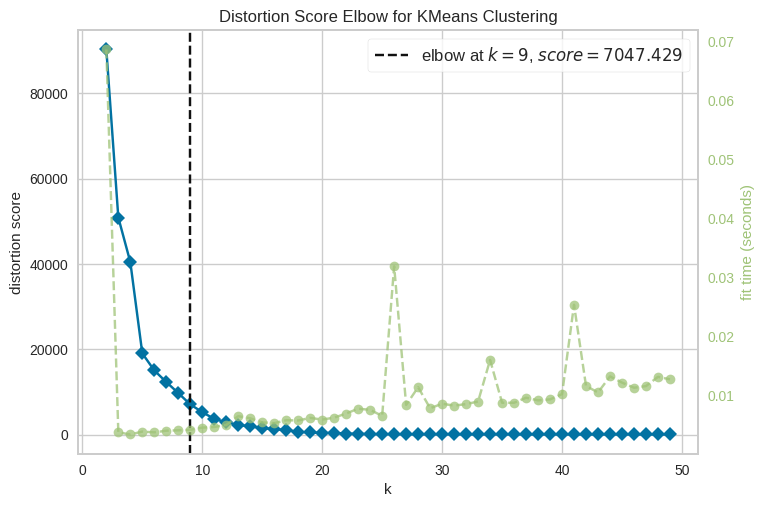

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# @title Watch the plot to see where the elbo (k) at
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define the model
kmean_model = KMeans(random_state=0, n_init='auto')

# Elbow method for KMeans
elbow_visualizer = KElbowVisualizer(kmean_model, k=(2, min(50, len(chosen_dt))))
elbow_visualizer.fit(tdt)
elbow_visualizer.show()

In [ ]:
# @title Plot Clustered Data using Kmeans
# Create sample data
np.random.seed(0)
embeddings = tdt
labels = ft_list

n_clusters = 9 # @param {type:"integer"}

# Perform k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
y_pred = kmeans.fit_predict(tdt)
centers=kmeans.cluster_centers_

# dff = dt.rename(columns={'t-SNE1': 'x', 't-SNE2': 'y'})
tdff = tdt.rename(columns={'UMAP1': 'x', 'UMAP2': 'y'})
tdff['label'] = labels
tdff['cluster'] = y_pred

# Create scatter plot with Plotly
fig = px.scatter(tdff, x='x', y='y', color='cluster', hover_data={'label': True})

# Add KMeans centers to the plot
fig.add_trace(go.Scatter(
    x=centers[:, 0], y=centers[:, 1],
    mode='markers',
    marker=dict(color='red', size=10, symbol='x'),
    name='Cluster Centers'
))

# Update layout to make it more interactive
fig.update_layout(
    title='Interactive Scatter Plot with Clusters',
    xaxis_title='X Axis',
    yaxis_title='Y Axis'
)

fig.show()

# EDA

In [ ]:
# @title Load dataframe
import pandas as pd

# Load the CSV file
file_path = f'data-{n_clusters_}-topics.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,title,topic,listing_id,price,quantity,views,est_sales,favorites,tags,category,categories,title.1,original_creation,last_modified,fixed_title
0,"Pro 1973 Roe Shirt, Vintage Pro Roe 1973 TShirt, Protect Roe vs. Wade Shirt, Roe 1973 Vintage Retro Shirt, Pro Choice Feminist Tee Gifts",Abortion,1261566365,2630,62937,48.0,1,3.0,"Feminist Shirt, Pro Choice, Abortion Rights, My Body My Choice, Reproductive Rights, Roe V Wade, Roe V Wade Shirt, 1973 Shirt, Protect Roe V Wade,...",T-shirts,Clothing > Gender-Neutral Adult Clothing > Tops & Tees > T-shirts,"Pro 1973 Roe Shirt, Vintage Pro Roe 1973 TShirt, Protect Roe vs. Wade Shirt, Roe 1973 Vintage Retro Shirt, Pro Choice Feminist Tee Gifts",2022-07-02T17:15:09Z,2023-08-13T22:04:00Z,"pro 1973 roe , vintage pro roe 1973 , protect roe vs. wade , roe 1973 vintage retro , pro choice feminist"
1,"Pro 1973 Roe Shirt, Vintage Pro Roe 1973 TShirt, Protect Roe vs. Wade Shirt, Roe 1973 Vintage Retro Shirt, Pro Choice Feminist Tee Gifts",Abortion,1401345216,1992,49944,78.0,1,5.0,"Feminist Shirt, Pro Choice Shirt, Abortion Rights, My Body My Choice, Reproductive Rights, Pro Roe V Wade, Roe V Wade Shirt, 1973 Shirt, Protect R...",T-shirts,Clothing > Gender-Neutral Adult Clothing > Tops & Tees > T-shirts,"Pro 1973 Roe Shirt, Vintage Pro Roe 1973 TShirt, Protect Roe vs. Wade Shirt, Roe 1973 Vintage Retro Shirt, Pro Choice Feminist Tee Gifts",2023-02-12T01:03:00Z,2024-05-11T10:37:12Z,"pro 1973 roe , vintage pro roe 1973 , protect roe vs. wade , roe 1973 vintage retro , pro choice feminist"
2,"Pro 1973 Roe Shirt, Vintage Pro Roe 1973 TShirt, Protect Roe vs. Wade Shirt, Roe 1973 Vintage Retro Shirt, Pro Choice Feminist Tee Gifts",Abortion,1415563771,1992,44955,20.0,0,2.0,"Feminist Shirt, Pro Choice Shirt, Abortion Rights, My Body My Choice, Reproductive Rights, Pro Roe V Wade, Roe V Wade Shirt, 1973 Shirt, Protect R...",T-shirts,Clothing > Gender-Neutral Adult Clothing > Tops & Tees > T-shirts,"Pro 1973 Roe Shirt, Vintage Pro Roe 1973 TShirt, Protect Roe vs. Wade Shirt, Roe 1973 Vintage Retro Shirt, Pro Choice Feminist Tee Gifts",2023-02-12T01:03:30Z,2024-02-15T01:30:30Z,"pro 1973 roe , vintage pro roe 1973 , protect roe vs. wade , roe 1973 vintage retro , pro choice feminist"
3,"Pro 1973 Roe Shirt, Vintage Pro Roe 1973 TShirt, Protect Roe vs. Wade Shirt, Roe 1973 Vintage Retro Shirt, Pro Choice Feminist Tee Gifts",Abortion,1415563849,1992,49950,19.0,0,NaN,"Feminist Shirt, Pro Choice Shirt, Abortion Rights, My Body My Choice, Reproductive Rights, Pro Roe V Wade, Roe V Wade Shirt, 1973 Shirt, Protect R...",T-shirts,Clothing > Gender-Neutral Adult Clothing > Tops & Tees > T-shirts,"Pro 1973 Roe Shirt, Vintage Pro Roe 1973 TShirt, Protect Roe vs. Wade Shirt, Roe 1973 Vintage Retro Shirt, Pro Choice Feminist Tee Gifts",2023-02-12T01:03:38Z,2024-02-15T01:30:31Z,"pro 1973 roe , vintage pro roe 1973 , protect roe vs. wade , roe 1973 vintage retro , pro choice feminist"
4,"No Country For Old Men, Feminist Shirt, Empowered Woman Shirt, Woman Empower Gift, Woman Gifts, Uterus Womens Rights Shirt, Pro Choice Gift",Abortion,1109050210,2370,998,118.0,2,8.0,"Feminist TShirt, Women Empower Gift, Minimalist T Shirt, Feminism T-Shirt, Women Tee, Empowered Women, Equal Rights Shirt, Womans Rights Shirt, No...",T-shirts,Clothing > Unisex Adult Clothing > Tops & Tees > T-shirts,"No Country For Old Men, Feminist Shirt, Empowered Woman Shirt, Woman Empower Gift, Woman Gifts, Uterus Womens Rights Shirt, Pro Choice Gift",2021-11-17T20:03:41Z,NaN,"no country for old , , empowered , empower , , uterus rights , pro choice"


In [ ]:
# @title Top **xx%** Items By Est Sales From **Month A** To **Month B**
# Convert the original_creation column to datetime
data['original_creation'] = pd.to_datetime(data['original_creation'])

top_percent = 0.42 # @param {type:"slider", min:0, max:1, step:0.01}
month_A = 8 # @param {type:"integer"}
month_B = 12 # @param {type:"integer"}

month_dict = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

# Filter items with original creation date from July to December (inclusive)
filtered_data = data[data['original_creation'].dt.month.isin(range(month_A, month_B + 1))]

# Group by topic and sort the groups alphabetically
grouped_data = filtered_data.groupby('topic')

# Function to get the top 30% items with the highest est_sales for each group
def get_top_xx_percent(group):
    group = group.sort_values(by='est_sales', ascending=False)
    top_30_percent = int(len(group) * 0.3)
    return group.head(top_30_percent)

# Apply the function to each group
top_xx_percent_items = grouped_data.apply(get_top_xx_percent).reset_index(drop=True)

top_xx_percent_items.head()

,title,topic,listing_id,price,quantity,views,est_sales,favorites,tags,category,categories,title.1,original_creation,last_modified,fixed_title
0,"Pro Life The Radical Idea That Babies Are People - Anti Abortion Shirt, Pro Life Black History, Republican Shirt, Christian Conservative",Abortion,1093535183,1992,49929,4502.0,110,551.0,"Pro Life Definition, lives matter shirt, pro choice shirt, human rights shirt, protest t-shirt, Anti-Abortion shirt, choose life shirt, Conservati...",T-shirts,Clothing > Unisex Adult Clothing > Tops & Tees > T-shirts,"Pro Life The Radical Idea That Babies Are People - Anti Abortion Shirt, Pro Life Black History, Republican Shirt, Christian Conservative",2021-09-29 21:57:28+00:00,2024-05-14T19:09:02Z,"pro life the radical idea that babies are people - anti abortion , pro life black history, republican , christian conservative"
1,"Do Something With Your life - Mediocre, Feminist shirt, womens rights, reproductive healthcare, abortion, Premium Men Woman Unisex Shirt",Abortion,901272280,1992,49944,3616.0,89,581.0,"Womens Rights, Roe Vs Wade, Abortion, Pro Choice, Anti Trump Shirt, Resist, Social Justice, Feminist Shirt, Protest Shirt, Mediocre White Man, Fem...",T-shirts,Clothing > Unisex Adult Clothing > Tops & Tees > T-shirts,"Do Something With Your life - Mediocre, Feminist shirt, womens rights, reproductive healthcare, abortion, Premium Men Woman Unisex Shirt",2020-11-30 20:53:29+00:00,2024-05-14T10:24:52Z,"do something with your life - mediocre, , rights, reproductive healthcare, abortion"
2,"Freedom Shirt, Republican Shirt, Abortion Rights Shirt, Pro-Choice Shirt, Feminism Shirt, Feminist Shirt, Womens Rights, Roe V Wade Shirt",Abortion,1151068877,1992,49949,1501.0,37,69.0,"feminist shirt, Pro choice t-shirt, Feminist tshirt, Feminism tshirt, Feminist tee shirt, Womens rights, Pro-Choice Shirt, Feminist T-shirt, femin...",T-shirts,Clothing > Unisex Adult Clothing > Tops & Tees > T-shirts,"Freedom Shirt, Republican Shirt, Abortion Rights Shirt, Pro-Choice Shirt, Feminism Shirt, Feminist Shirt, Womens Rights, Roe V Wade Shirt",2021-12-30 19:06:18+00:00,2023-08-15T04:50:35Z,"freedom , republican , abortion rights , pro-choice , feminism , , rights, roe v wade"
3,"Donkey Gifts, Donkey Shirt, Animal Lover, Easily Distracted By Donkeys, Mule Shirt, Pet Donkey Shirt, Donkey Lover, Mens Womens Unisex Shirt",Animals,1077217725,1990,49864,3163.0,77,253.0,"Donkey Shirt, Animal Lover, Pet Donkey Shirt, Donkey Lover, Donkey Humor, Mule Gift, Pet Donkey Gift, Easily Distracted By, Donkeys Shirt, girlfri...",T-shirts,Clothing > Unisex Adult Clothing > Tops & Tees > T-shirts,"Donkey Gifts, Donkey Shirt, Animal Lover, Easily Distracted By Donkeys, Mule Shirt, Pet Donkey Shirt, Donkey Lover, Mens Womens Unisex Shirt",2021-08-31 21:57:50+00:00,2024-05-09T11:36:28Z,"donkey , donkey , animal lover, easily distracted by donkeys, mule , pet donkey , donkey lover"
4,"Goats Are Like Mushrooms Because If You Shoot - Biden T-Shirt, Political Shirt, Anti Biden Shirt, Republican Shirt, Anti Democrat Shirt",Animals,1074348336,1992,49938,2056.0,50,53.0,"Republican shirt, Conservative shirt, republican gift, republican party, anti democrat shirt, Anti Biden Shirt, republican shirts, Anti Joe Biden,...",T-shirts,Clothing > Unisex Adult Clothing > Tops & Tees > T-shirts,"Goats Are Like Mushrooms Because If You Shoot - Biden T-Shirt, Political Shirt, Anti Biden Shirt, Republican Shirt, Anti Democrat Shirt",2021-09-21 00:28:20+00:00,2024-06-07T16:36:40Z,"goats are like mushrooms because if you shoot - biden , political , anti biden , republican , anti"


In [ ]:
# @title Save top **xx%** Items By Est Sales From **Month A** To **Month B**
# Save the resulting dataframe to a CSV file
output_file_path = f'/content/Top_{int(top_percent * 100)}_Percent_Items_{month_dict[month_A]}_To_{month_dict[month_B]}.csv'
top_xx_percent_items.to_csv(output_file_path, index=False)

output_file_path

'/content/Top_42_Percent_Items_August_To_December.csv'

Detailed analysis for each topic


---


1.   **Total number of items.**             
2.   **Total estimated sales.**
3.   **Average estimated sales per item.**
4.   **Total views.**
5.   **Average views per item.**
6.   **Total favorites.**
7.   **Average favorites per item.**
8.   **Average price.**

In [ ]:
# @title Detailed analysis for each topic
# Grouping the top xx percent items by topic
topic_groups = top_xx_percent_items.groupby('topic')

# Preparing the analysis data
analysis_data = topic_groups.agg(
    total_items=('listing_id', 'count'),
    total_est_sales=('est_sales', 'sum'),
    avg_est_sales_per_item=('est_sales', 'mean'),
    total_views=('views', 'sum'),
    avg_views_per_item=('views', 'mean'),
    total_favorites=('favorites', 'sum'),
    avg_favorites_per_item=('favorites', 'mean'),
    avg_price=('price', 'mean')
).reset_index()

analysis_data.head()

,topic,total_items,total_est_sales,avg_est_sales_per_item,total_views,avg_views_per_item,total_favorites,avg_favorites_per_item,avg_price
0,Abortion,3,236,78.666667,9619.0,3206.333333,1201.0,400.333333,1992.000000
1,Animals,9,267,29.666667,11062.0,1229.111111,552.0,61.333333,1890.777778
2,Autism,1,10,10.000000,415.0,415.000000,15.0,15.000000,1992.000000
3,Baking,1,22,22.000000,905.0,905.000000,40.0,40.000000,1992.000000
4,Books,6,153,25.500000,6346.0,1057.666667,486.0,81.000000,1992.000000


In [ ]:
# @title Save detailed analysis for each topic

analysis_data.to_csv(f'/content/Detailed_Analysis_{n_clusters_}-Topics.csv', index=False)
f'/content/Detailed_Analysis_{n_clusters_}-Topics.csv'

'/content/Detailed_Analysis_98-Topics.csv'

In [ ]:
# @title Filter items with estimated sales greater than **XX** from **Month A** to **Month B** and grouped by topic.
# Load the new CSV file
new_file_path = f'data-{n_clusters_}-topics.csv'
new_data = pd.read_csv(new_file_path)

XX = 30 #@param {type:"integer"}
month_A = 7 # @param {type:"integer"}
month_B = 12 # @param {type:"integer"}

# Convert the original_creation column to datetime
new_data['original_creation'] = pd.to_datetime(new_data['original_creation'])

# Filter items with original creation date from July to December (inclusive)
filtered_new_data = new_data[new_data['original_creation'].dt.month.isin([7, 8, 9, 10, 11, 12])]

# Group by topic and sort the groups alphabetically
grouped_new_data = filtered_new_data.groupby('topic')

# Function to filter items with est_sales greater than 30 for each group
def filter_sales_greater_than_xx(group):
    return group[group['est_sales'] > XX]

# Apply the function to each group
filtered_sales_data = grouped_new_data.apply(filter_sales_greater_than_xx).reset_index(drop=True)

filtered_sales_data.head()

,title,topic,listing_id,price,quantity,views,est_sales,favorites,tags,category,categories,title.1,original_creation,last_modified,fixed_title
0,"Do Something With Your life - Mediocre, Feminist shirt, womens rights, reproductive healthcare, abortion, Premium Men Woman Unisex Shirt",Abortion,901272280,1992,49944,3616.0,89,581.0,"Womens Rights, Roe Vs Wade, Abortion, Pro Choice, Anti Trump Shirt, Resist, Social Justice, Feminist Shirt, Protest Shirt, Mediocre White Man, Fem...",T-shirts,Clothing > Unisex Adult Clothing > Tops & Tees > T-shirts,"Do Something With Your life - Mediocre, Feminist shirt, womens rights, reproductive healthcare, abortion, Premium Men Woman Unisex Shirt",2020-11-30 20:53:29+00:00,2024-05-14T10:24:52Z,"do something with your life - mediocre, , rights, reproductive healthcare, abortion"
1,"Pro 1973 Roe Shirt, Vintage Pro Roe 1973 TShirt, Protect Roe vs. Wade Shirt, Roe 1973 Vintage Retro Shirt, Pro Choice Feminist Tee Gifts",Abortion,1255993400,1990,49793,5959.0,146,341.0,"Feminist Shirt, Pro Choice, Abortion Rights, My Body My Choice, Reproductive Rights, Roe V Wade, Roe V Wade Shirt, 1973 Shirt, Protect Roe V Wade,...",T-shirts,Clothing > Gender-Neutral Adult Clothing > Tops & Tees > T-shirts,"Pro 1973 Roe Shirt, Vintage Pro Roe 1973 TShirt, Protect Roe vs. Wade Shirt, Roe 1973 Vintage Retro Shirt, Pro Choice Feminist Tee Gifts",2022-07-17 23:15:37+00:00,2024-05-17T15:49:50Z,"pro 1973 roe , vintage pro roe 1973 , protect roe vs. wade , roe 1973 vintage retro , pro choice feminist"
2,"Pro Life The Radical Idea That Babies Are People - Anti Abortion Shirt, Pro Life Black History, Republican Shirt, Christian Conservative",Abortion,1093535183,1992,49929,4502.0,110,551.0,"Pro Life Definition, lives matter shirt, pro choice shirt, human rights shirt, protest t-shirt, Anti-Abortion shirt, choose life shirt, Conservati...",T-shirts,Clothing > Unisex Adult Clothing > Tops & Tees > T-shirts,"Pro Life The Radical Idea That Babies Are People - Anti Abortion Shirt, Pro Life Black History, Republican Shirt, Christian Conservative",2021-09-29 21:57:28+00:00,2024-05-14T19:09:02Z,"pro life the radical idea that babies are people - anti abortion , pro life black history, republican , christian conservative"
3,"Freedom Shirt, Republican Shirt, Abortion Rights Shirt, Pro-Choice Shirt, Feminism Shirt, Feminist Shirt, Womens Rights, Roe V Wade Shirt",Abortion,1151068877,1992,49949,1501.0,37,69.0,"feminist shirt, Pro choice t-shirt, Feminist tshirt, Feminism tshirt, Feminist tee shirt, Womens rights, Pro-Choice Shirt, Feminist T-shirt, femin...",T-shirts,Clothing > Unisex Adult Clothing > Tops & Tees > T-shirts,"Freedom Shirt, Republican Shirt, Abortion Rights Shirt, Pro-Choice Shirt, Feminism Shirt, Feminist Shirt, Womens Rights, Roe V Wade Shirt",2021-12-30 19:06:18+00:00,2023-08-15T04:50:35Z,"freedom , republican , abortion rights , pro-choice , feminism , , rights, roe v wade"
4,"Donkey Gifts, Donkey Shirt, Animal Lover, Easily Distracted By Donkeys, Mule Shirt, Pet Donkey Shirt, Donkey Lover, Mens Womens Unisex Shirt",Animals,1077217725,1990,49864,3163.0,77,253.0,"Donkey Shirt, Animal Lover, Pet Donkey Shirt, Donkey Lover, Donkey Humor, Mule Gift, Pet Donkey Gift, Easily Distracted By, Donkeys Shirt, girlfri...",T-shirts,Clothing > Unisex Adult Clothing > Tops & Tees > T-shirts,"Donkey Gifts, Donkey Shirt, Animal Lover, Easily Distracted By Donkeys, Mule Shirt, Pet Donkey Shirt, Donkey Lover, Mens Womens Unisex Shirt",2021-08-31 21:57:50+00:00,2024-05-09T11:36:28Z,"donkey , donkey , animal lover, easily distracted by donkeys, mule , pet donkey , donkey lover"


In [ ]:
# @title Save filtered items with estimated sales greater than XX from Month A to Month B and grouped by topic.
# Save the filtered sales data to a CSV file
output_filtered_sales_file_path = f'/content/Items_with_Est_Sales_Greater_Than_{XX}_{month_dict[month_A]}_to_{month_dict[month_B]}.csv'
filtered_sales_data.to_csv(output_filtered_sales_file_path, index=False)

output_filtered_sales_file_path

'/content/Items_with_Est_Sales_Greater_Than_30_July_to_December.csv'

In [ ]:
# @title Top xx keywords for each topic from month_A to month_B
# Load the newly uploaded CSV file
latest_file_path = f'data-{n_clusters_}-topics.csv'
latest_data = pd.read_csv(latest_file_path)

xx = 5 #@param {type:"integer"}
month_A = 7 # @param {type:"integer"}
month_B = 12 # @param {type:"integer"}

# Convert the original_creation column to datetime
latest_data['original_creation'] = pd.to_datetime(latest_data['original_creation'])

# Filter items with original creation date from July to December (inclusive)
filtered_latest_data = latest_data[latest_data['original_creation'].dt.month.isin(range(month_A, month_B))]

# Group by topic and sort the groups alphabetically
grouped_latest_data = filtered_latest_data.groupby('topic')

# Function to extract top xx keywords for each group
def extract_top_keywords(group):
    keywords = group['tags'].str.cat(sep=',').split(',')
    keywords = [keyword.strip() for keyword in keywords if keyword.strip()]
    keyword_counts = pd.Series(keywords).value_counts()
    top_keywords = keyword_counts.head(xx).index.tolist()
    return pd.Series(top_keywords, index=[f'top_keyword_{i+1}' for i in range(len(top_keywords))])

# Apply the function to each group
top_keywords_data = grouped_latest_data.apply(extract_top_keywords).reset_index()

top_keywords_data.head()

,topic,top_keyword_1,top_keyword_2,top_keyword_3,top_keyword_4,top_keyword_5
0,Abortion,Feminist Shirt,Pro Choice,reproductive rights,Abortion Rights,Womens Rights Shirt
1,Alternative,retired emo kid,emo kid shirt,emo shirt,goth shirt,aesthetic clothing
2,Animals,kid shirt,gifts best friend,funny shirts,whale shirt,Whale pun
3,Autism,special education,boho rainbow shirt,sped teacher tee,see the able tee,occupational therapy
4,Bachelorette,Brother in law Gift,Wedding Party Shirt,Gift From Bride,Groomsmen Shirt,Bachelor Party


In [ ]:
# @title Save top xx keywords for each topic

top_keywords_data.to_csv(f'/content/Top_{xx}_Keywords_from_{month_dict[month_A]}_to_{month_dict[month_B]}_by_Topic.csv', index=False)
f'/content/Top_{xx}_Keywords_from_{month_dict[month_A]}_to_{month_dict[month_B]}_by_Topic.csv'

'/content/Top_5_Keywords_from_July_to_December_by_Topic.csv'

In [ ]:
# @title Filter all keywords/sub niches by bestselling items of each topic
# Load the newly uploaded CSV file
bestselling_file_path = f'data-{n_clusters_}-topics.csv'
bestselling_data = pd.read_csv(bestselling_file_path)

# Convert the original_creation column to datetime
bestselling_data['original_creation'] = pd.to_datetime(bestselling_data['original_creation'])

# Filter items with original creation date from July to December (inclusive)
filtered_bestselling_data = bestselling_data[bestselling_data['original_creation'].dt.month.isin([7, 8, 9, 10, 11, 12])]

# Group by topic and filter items with the highest estimated sales
def filter_top_bestselling_items(group):
    return group[group['est_sales'] == group['est_sales'].max()]

top_bestselling_items = filtered_bestselling_data.groupby('topic').apply(filter_top_bestselling_items).reset_index(drop=True)

# Extract keywords for the top bestselling items by topic
top_keywords_bestselling_data = top_bestselling_items.groupby('topic')['tags'].apply(lambda x: ', '.join(x)).reset_index()

# Split the concatenated tags into individual keywords
top_keywords_bestselling_data['all_keywords'] = top_keywords_bestselling_data['tags'].apply(lambda x: list(set([keyword.strip() for keyword in x.split(',')])))

# Drop the original concatenated tags column
top_keywords_bestselling_data = top_keywords_bestselling_data.drop(columns=['tags'])

top_keywords_bestselling_data.head()

,topic,all_keywords
0,Abortion,"[Protect Roe V Wade, 1973 T Shirt, Minimalist Feminist, Feminist Shirt, Abortion Rights, Reproductive Rights, Roe V Wade Shirt, 1973 Shirt, Pro Ch..."
1,Alternative,"[emo kid shirt, emo shirt, grunge, introvert shirt, funny emo shirt, retired emo kid, mental health shirt, anxiety shirts, geek shirt, aesthetic c..."
2,Animals,"[Animal Lover, Donkey Gifts, Donkey Lover, Easily Distracted By, Donkey Humor, Mule Gift, Pet Donkey Gift, girlfriend gift, donkey farm, Pet Donke..."
3,Autism,"[occupational therapy, sped teacher tee, teacher shirt, disability awareness, sped teacher shirt, speech pathologist, sped shirt, back to school s..."
4,Bachelorette,"[Rehearsal Party, Wedding Party Shirt, Groomsmen Shirt, Gift From Bride, Grooms Crew Shirt, Unisex Shirt, Brother in law Gift, Brides Big Bro, Gro..."


In [ ]:
# @title Save filtered all keywords by bestselling items of each topic

top_keywords_bestselling_data.to_csv(f'/content/All_Keywords_by_Bestselling_Items_of_Each_Topic.csv', index=False)
f'/content/All_Keywords_by_Bestselling_Items_of_Each_Topic.csv'

'/content/All_Keywords_by_Bestselling_Items_of_Each_Topic.csv'

In [ ]:
# @title Filter **top XX** keywords having **threholds** or more words by topic
# Load the newly uploaded CSV file
final_bestselling_file_path = f'data-{n_clusters_}-topics.csv'
final_bestselling_data = pd.read_csv(final_bestselling_file_path)

top_XX = 10 #@param {type:"integer"}
threshold = 3 #@param {type:"integer"}

# Convert the original_creation column to datetime
final_bestselling_data['original_creation'] = pd.to_datetime(final_bestselling_data['original_creation'])

# Filter items with original creation date from July to December (inclusive)
filtered_final_bestselling_data = final_bestselling_data[final_bestselling_data['original_creation'].dt.month.isin([7, 8, 9, 10, 11, 12])]

# Group by topic and filter items with the highest estimated sales
def filter_top_bestselling_items(group):
    return group[group['est_sales'] == group['est_sales'].max()]

top_bestselling_items_final = filtered_final_bestselling_data.groupby('topic').apply(filter_top_bestselling_items).reset_index(drop=True)

# Extract keywords for the top bestselling items by topic
top_keywords_bestselling_data_final = top_bestselling_items_final.groupby('topic')['tags'].apply(lambda x: ', '.join(x)).reset_index()

# Split the concatenated tags into individual keywords
top_keywords_bestselling_data_final['all_keywords'] = top_keywords_bestselling_data_final['tags'].apply(lambda x: list(set([keyword.strip() for keyword in x.split(',')])))

# Filter keywords having threshold or more words and get top_XX by frequency
def filter_keywords(keywords):
    filtered_keywords = [kw for kw in keywords if len(kw.split()) >= threshold]
    keyword_counts = pd.Series(filtered_keywords).value_counts()
    return keyword_counts.head(top_XX).index.tolist()

top_keywords_bestselling_data_final[f'top_{top_XX}_keywords'] = top_keywords_bestselling_data_final['all_keywords'].apply(filter_keywords)

# Drop the original concatenated tags column and all_keywords column
top_keywords_bestselling_data_final = top_keywords_bestselling_data_final.drop(columns=['tags', 'all_keywords'])

top_keywords_bestselling_data_final.head()

,topic,top_10_keywords
0,Abortion,"[Protect Roe V Wade, 1973 T Shirt, Roe V Wade Shirt, Roe V Wade, My Body My Choice, Womens Rights Shirt, Roe V Wade 1973]"
1,Alternative,"[emo kid shirt, funny emo shirt, retired emo kid, mental health shirt, shirt with sayings]"
2,Animals,"[Easily Distracted By, Pet Donkey Gift, Pet Donkey Shirt]"
3,Autism,"[sped teacher tee, sped teacher shirt, back to school shirt, see the able tee, not the label shirt, boho rainbow shirt]"
4,Bachelorette,"[Wedding Party Shirt, Gift From Bride, Grooms Crew Shirt, Brother in law Gift, Brides Big Bro, Brother Of The Bride, Best Man Gift]"


In [ ]:
# @title Save filtered **top XX** keywords having **threholds** or more words by topic

top_keywords_bestselling_data_final.to_csv(f'/content/Top_{top_XX}_Keywords_Having_{threshold}_Or_More_Words_by_Topic.csv', index=False)
f'/content/Top_{top_XX}_Keywords_Having_{threshold}_Or_More_Words_by_Topic.csv'

'/content/Top_10_Keywords_Having_3_Or_More_Words_by_Topic.csv'

In [ ]:
# @title The smaller topics by each main topic from month_A to month_B
# Load the CSV file
small_topic_file_path = f'data-{n_clusters_}-topics.csv'
small_topic_data = pd.read_csv(small_topic_file_path)

# Set the month range for filtering
month_A = 7 # @param {type:"integer"}
month_B = 12 # @param {type:"integer"}

# Convert the original_creation column to datetime
small_topic_data['original_creation'] = pd.to_datetime(small_topic_data['original_creation'])

# Filter items with original creation date from July to December (inclusive)
filtered_small_topic_data = small_topic_data[small_topic_data['original_creation'].dt.month.isin(range(month_A, month_B))]

# Extract the 'topic' and 'tags' columns
topic_tags_data = filtered_small_topic_data[['topic', 'tags']]

# Split tags into individual keywords and create a dataframe of unique combinations
topic_tags_data['tags'] = topic_tags_data['tags'].fillna('')
topic_tags_data['keywords'] = topic_tags_data['tags'].apply(lambda x: [keyword.strip() for keyword in x.split(',') if keyword.strip()])

# Explode the keywords into individual rows
exploded_keywords_data = topic_tags_data.explode('keywords').drop(columns=['tags'])

# Group by topic and keywords, count the occurrences
small_topics = exploded_keywords_data.groupby(['topic', 'keywords']).size().reset_index(name='count')

# Filter keywords with counts greater than 1 to consider them as smaller topics
small_topics_filtered = small_topics[small_topics['count'] > 1]

small_topics_filtered.head()

<ipython-input-34-c8607d955a43>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-34-c8607d955a43>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,topic,keywords,count
1,Abortion,1973 Shirt,4
2,Abortion,1973 T Shirt,4
3,Abortion,Abortion,3
4,Abortion,Abortion Access,2
5,Abortion,Abortion Rights,7


In [ ]:
# @title Save smaller topics by each main topic from month_A to month_B

small_topics_filtered.to_csv(f'/content/Smaller_Topics_by_Each_Main_Topic_from_{month_dict[month_A]}_to_{month_dict[month_B]}.csv', index=False)
f'/content/Smaller_Topics_by_Each_Main_Topic_from_{month_dict[month_A]}_to_{month_dict[month_B]}.csv'

'/content/Smaller_Topics_by_Each_Main_Topic_from_July_to_December.csv'

<ipython-input-36-37a5074f75e4>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




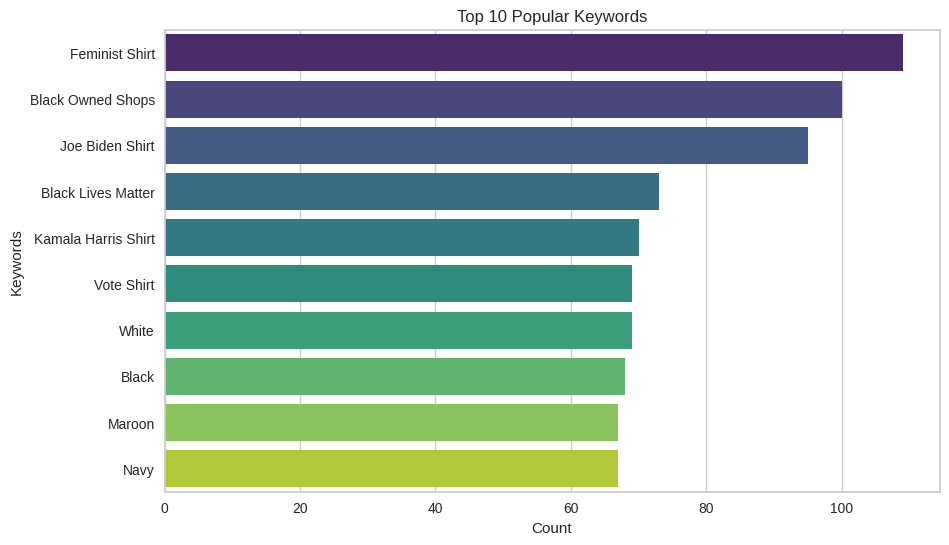

In [ ]:
# @title Highlight popular keywords
import matplotlib.pyplot as plt
import seaborn as sns

# Find popular keywords by counting occurrences across all topics
popular_keywords = small_topics_filtered.groupby('keywords')['count'].sum().reset_index()

# Highlight popular keywords with the highest count
popular_keywords_sorted = popular_keywords.sort_values(by='count', ascending=False).head(10)

# Plotting the popular keywords
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='keywords', data=popular_keywords_sorted, palette='viridis')
plt.title('Top 10 Popular Keywords')
plt.xlabel('Count')
plt.ylabel('Keywords')
plt.show()